# Coffee Market Analysis
## Exploratory Data Analysis Notebook (2)

### Matthew Garton - February 2019

**Purpose:** The purpose of this notebook is to perform Exploratory Data Analysis on my coffee dataset, to examine relationships between variables, distributions, and try to determine which variables will be most useful for predicting coffee prices. I started a new notebook to try a different approach. Rather than starting with the full dataset - I want to separate each set of predictors to examine relationships one at a time (Fundamental Data, Weather Data, Technical Data). Once I have figured out the relationships that have value for prediction, then I can incorporate those into a model.

**Context**: The ultimate goal of my project is to develop trading signals for coffee futures. I will attempt to build a machine learning model which uses fundamental and technical data to predict the future direction of coffee futures price changes. My expectation at the outset of this project is that my feature matrix will include data on weather, GDP, and coffee production and exports in major coffee-producing nations, GDP and coffee import data in major coffee-importing nations, as well as volume, open-interest, and commitment of traders data for ICE coffee futures contracts.

This notebook imports a cleaner dataset that I prepared in the Data Wrangling Notebook, called CoffeeDataset. See '../data/' for all of the raw data that I started with, or the links in the Data Wrangling Notebook to get the data directly from the source.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.regression.linear_model import OLS

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [10]:
# import the dataset
coffee = pd.read_csv('../data/CoffeeDataset.csv')
coffee['Date'] = pd.to_datetime(coffee['Date'])
coffee.set_index('Date', inplace=True)

In [11]:
coffee.columns

Index(['Open', 'High', 'Low', 'Settle', 'Volume', 'BRA_Temp', 'BRA_Precip',
       'COL_Precip', 'COL_Temp', 'ETH_Precip', 'ETH_Temp', 'IDN_Precip',
       'IDN_Temp', 'VNM_Precip', 'VNM_Temp', 'Production',
       'Consumption (domestic)', 'Exportable Production',
       'Gross Opening Stocks', 'Exports', 'Imports', 'Re-exports',
       'Inventories', 'Disappearance', 'Open_Interest_All',
       'NonComm_Positions_Long_All', 'NonComm_Positions_Short_All',
       'NonComm_Postions_Spread_All', 'Comm_Positions_Long_All',
       'Comm_Positions_Short_All', 'Tot_Rept_Positions_Long_All',
       'Tot_Rept_Positions_Short_All', 'NonRept_Positions_Long_All',
       'NonRept_Positions_Short_All', 'Pct_of_OI_NonComm_Long_All',
       'Pct_of_OI_NonComm_Short_All', 'Pct_of_OI_NonComm_Spread_All',
       'Pct_of_OI_Comm_Long_All', 'Pct_of_OI_Comm_Short_All',
       'Pct_of_OI_Tot_Rept_Long_All', 'Pct_of_OI_Tot_Rept_Short_All',
       'Pct_of_OI_NonRept_Long_All', 'Pct_of_OI_NonRept_Short_All',
 

## 1) Price and Fundamentals

First, I'd like to examine the relationships between prices and the fundamental data that I have gathered from ICO. In order to best capture the relationships, I will look at the effect of the level of each feature on the level of prices, as well as the effect of changes in each feature on both price levels and price changes.

In [17]:
df = coffee[['Settle','Production',
             'Disappearance','Exports',
             'Imports','Inventories']].resample('A').last()

In [18]:
df.rename(columns={'Settle':'Price'}, inplace=True)

In [22]:
def get_forward_returns(df, ranges):
    for r in ranges:
        df['{}D_Return'.format(r)] = df['Price'].pct_change(r).shift(-r)

In [20]:
get_forward_returns(df, [1])

In [21]:
df.head()

,Price,Production,Disappearance,Exports,Imports,Inventories,1M_Return
Date,,,,,,,
1994-12-31,168.85,90646.3016,63742.220601,70716.497596,75024.0,14789.0,-0.437963
1995-12-31,94.90,93217.4970,65593.109721,67871.905200,72371.0,9287.0,0.231823
1996-12-31,116.90,87056.4742,66780.173497,77685.145890,77854.0,7716.0,0.389649
1997-12-31,162.45,103251.6420,66524.900726,80413.637943,81063.0,8447.0,-0.275162
1998-12-31,117.75,99666.9910,67927.357276,80265.158973,82767.0,8204.0,0.069214


In [8]:
last_px = 126.20
old_px = 137.05
df = df.fillna(value=(last_px - old_px)/old_px)

In [9]:
def plot_series(df, cols, pos=1):
    
    ax1 = fig.add_subplot(3, 2, pos)
    ax1.plot(df[cols[0]].dropna(), color='k', label=cols[0])

    ax2 = ax1.twinx()
    ax2.plot(df[cols[1]].dropna(),color='b', label=cols[1])

    plt.title('{} and {}'.format(cols[0],cols[1]), fontsize=18)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2);

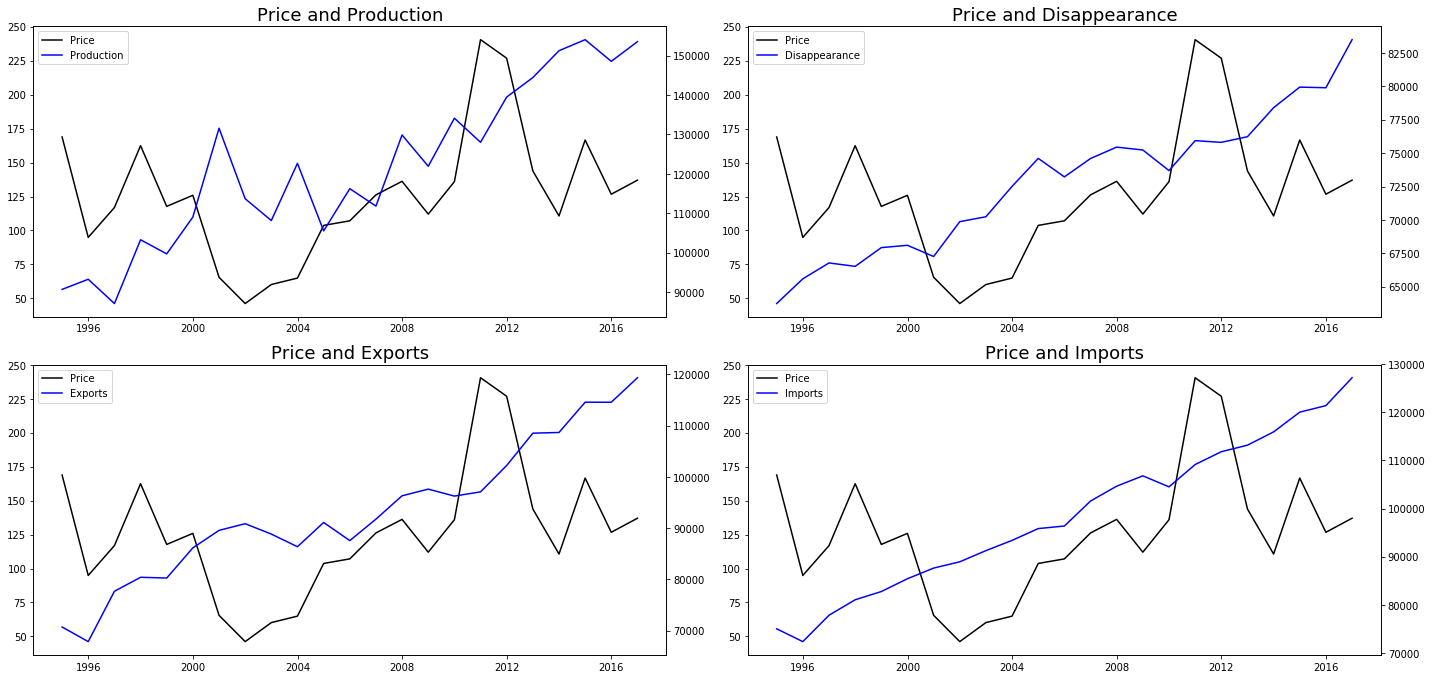

In [10]:
fig = plt.figure(figsize=(20,14))
plot_series(df, cols=['Price','Production'])
plot_series(df, cols=['Price','Disappearance'], pos=2)
plot_series(df, cols=['Price','Exports'], pos=3)
plot_series(df, cols=['Price','Imports'], pos=4)
plt.tight_layout();

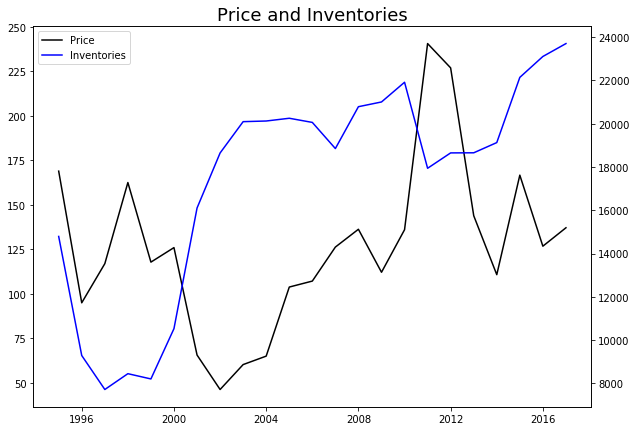

In [11]:
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111)
ax1.plot(df['Price'], color='k', label='Price')

ax2 = ax1.twinx()
ax2.plot(df['Inventories'], color='b', label='Inventories')

plt.title('Price and Inventories', fontsize=18)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2);

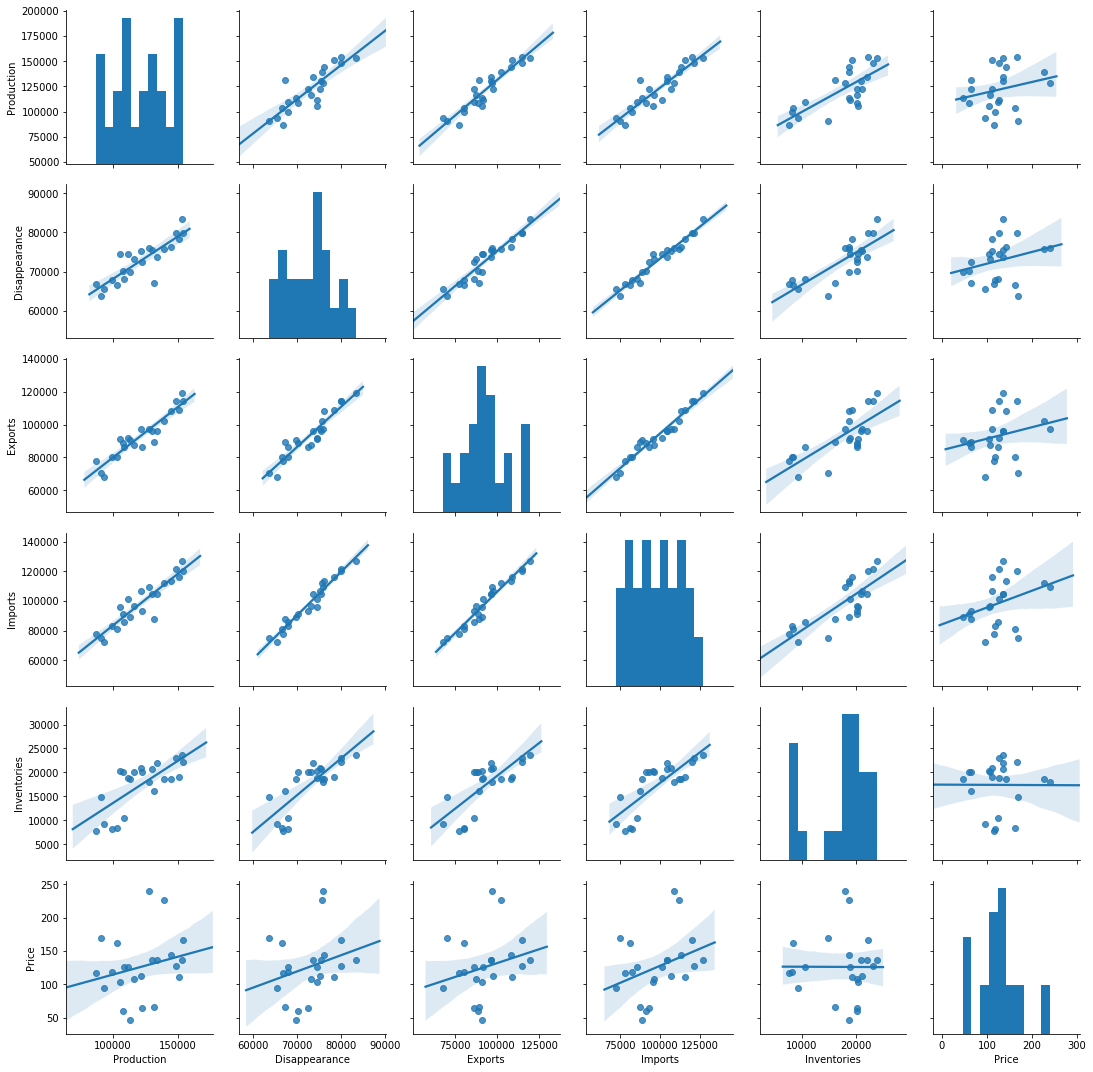

In [12]:
sns.pairplot(vars=['Production', 'Disappearance', 'Exports', 
                   'Imports', 'Inventories','Price'], 
             data=df,
             kind='reg');

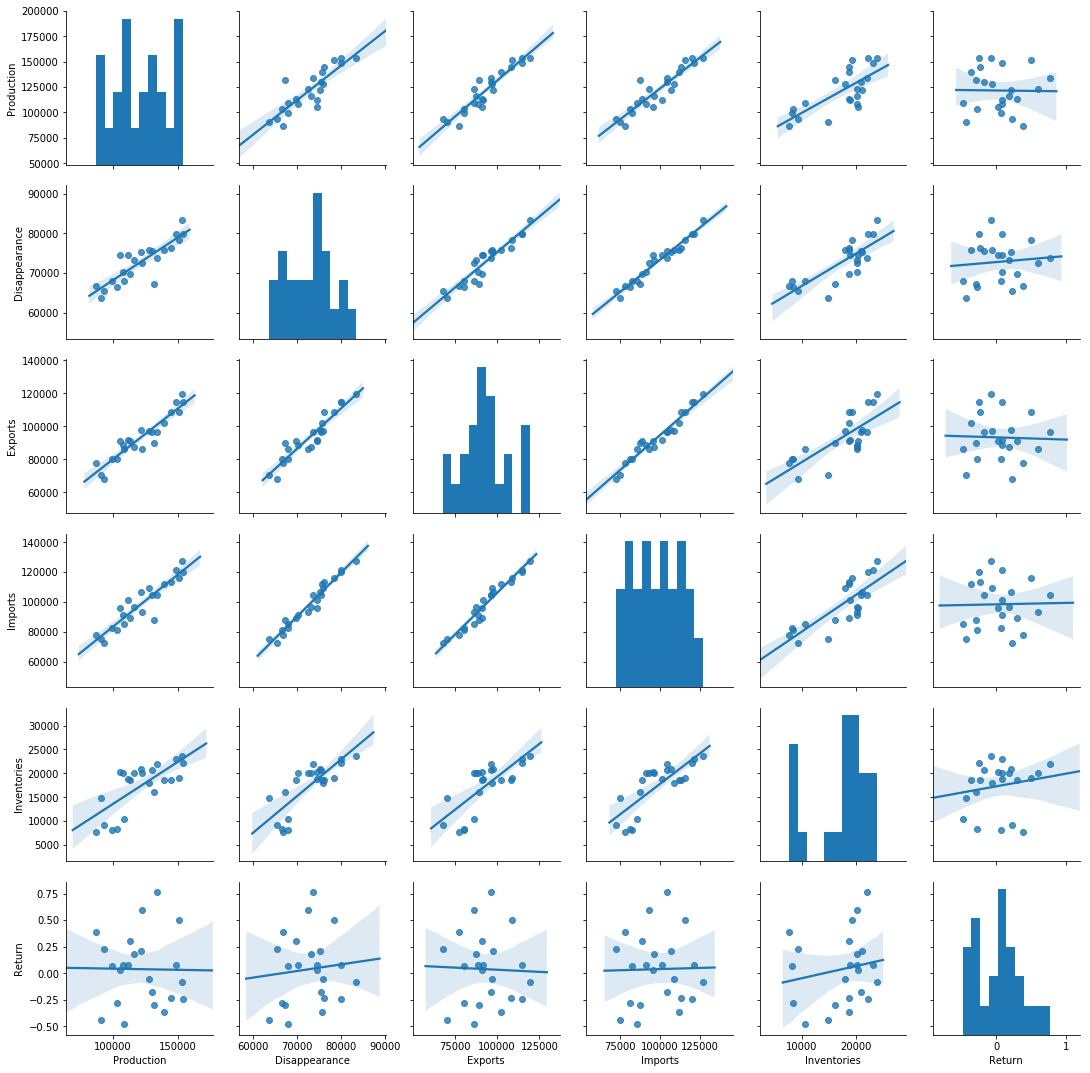

In [14]:
sns.pairplot(vars=['Production', 'Disappearance', 'Exports', 
                   'Imports', 'Inventories','Return'], 
             data=df,
             kind='reg');

### Looking at changes in fundamentals

In [15]:
fundamentals = ['Production', 'Disappearance', 'Exports', 'Imports', 'Inventories']

for f in fundamentals:
    df['{}_Chg'.format(f)] = df[f].diff()

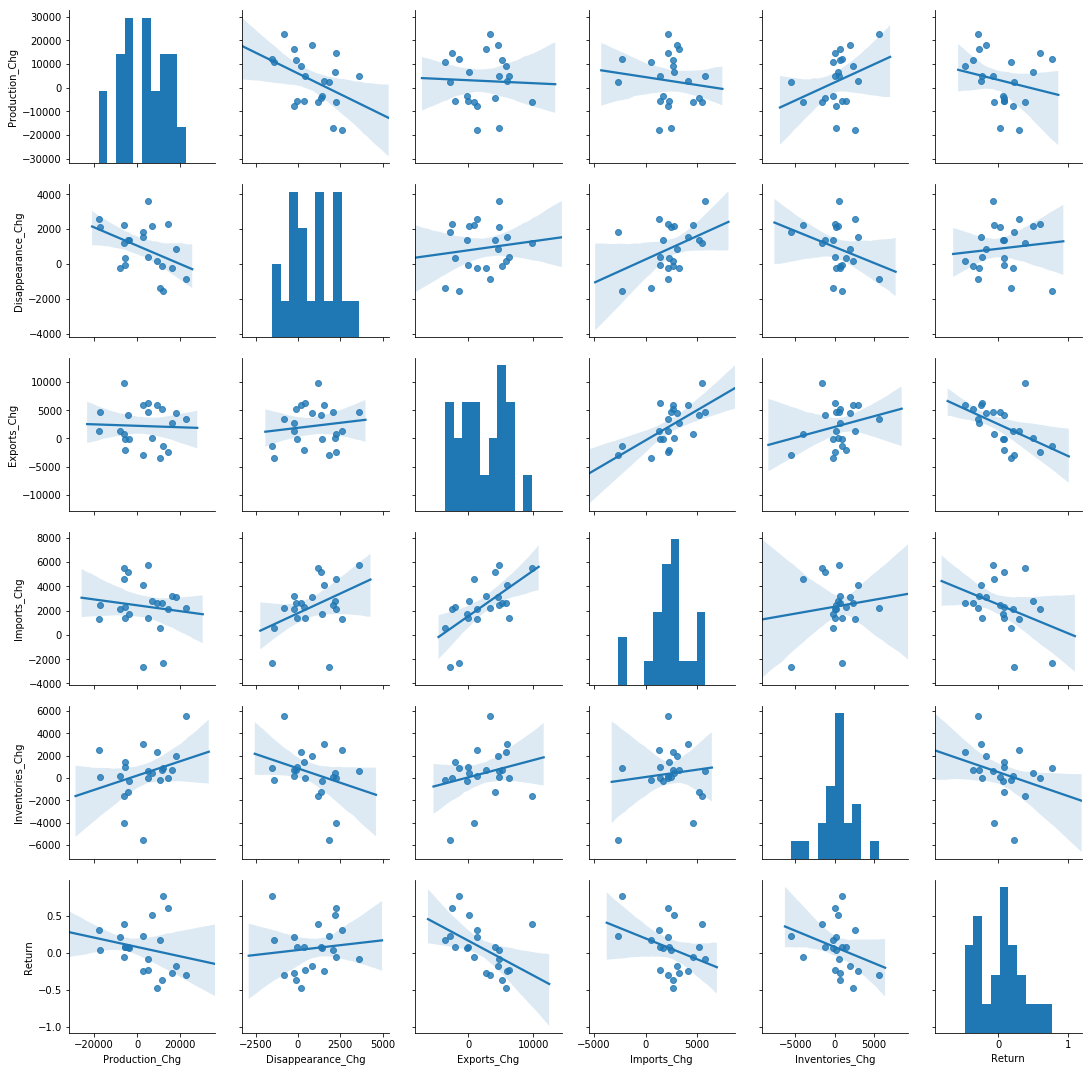

In [17]:
sns.pairplot(vars=['Production_Chg', 'Disappearance_Chg', 'Exports_Chg', 
                   'Imports_Chg', 'Inventories_Chg','Return'], 
             data=df,
             kind='reg');

### Regression 1: Using Levels to Predict Price

In [19]:
X = df[['Production', 'Disappearance', 'Exports', 'Imports', 'Inventories']]
y = df['Price']

model = OLS(y,X)

In [20]:
lr = model.fit()

In [21]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     60.60
Date:                Tue, 26 Feb 2019   Prob (F-statistic):           1.25e-10
Time:                        11:53:36   Log-Likelihood:                -112.19
No. Observations:                  23   AIC:                             234.4
Df Residuals:                      18   BIC:                             240.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Production       5.1e-06      0.001      0.005      0.996      -0.002       0.002
Disappearance     0.0003      0.001      0.245      0.809      -0.003       0.003
Exports          -0.0068      0.003     -2.426      0.026      -0.013      -0.001
Imports           0.0089      0.002      3.785      0.001       0.004       0.014
Inventories      -0.0085      0.003     -3.362      0.003      -0.014      -0.003
==============================================================================
Omnibus:                        2.704   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                1.683
Skew:                           0.661   Prob(JB):                        0.431
Kurtosis:                       3.090   Cond. No.                         94.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
df['Price_Lag'] = df['Price'].shift(1)

In [23]:
px_93 = 71.55

In [24]:
df.fillna(value=px_93, inplace=True)
df.head()

,Price,Production,Disappearance,Exports,Imports,Inventories,Return,Production_Chg,Disappearance_Chg,Exports_Chg,Imports_Chg,Inventories_Chg,Price_Lag
Date,,,,,,,,,,,,,
1994-12-31,168.85,90646.3016,63742.220601,70716.497596,75024.0,14789.0,-0.437963,71.5500,71.550000,71.550000,71.55,71.55,71.55
1995-12-31,94.90,93217.4970,65593.109721,67871.905200,72371.0,9287.0,0.231823,2571.1954,1850.889120,-2844.592396,-2653.00,-5502.00,168.85
1996-12-31,116.90,87056.4742,66780.173497,77685.145890,77854.0,7716.0,0.389649,-6161.0228,1187.063776,9813.240690,5483.00,-1571.00,94.90
1997-12-31,162.45,103251.6420,66524.900726,80413.637943,81063.0,8447.0,-0.275162,16195.1678,-255.272771,2728.492053,3209.00,731.00,116.90
1998-12-31,117.75,99666.9910,67927.357276,80265.158973,82767.0,8204.0,0.069214,-3584.6510,1402.456550,-148.478970,1704.00,-243.00,162.45


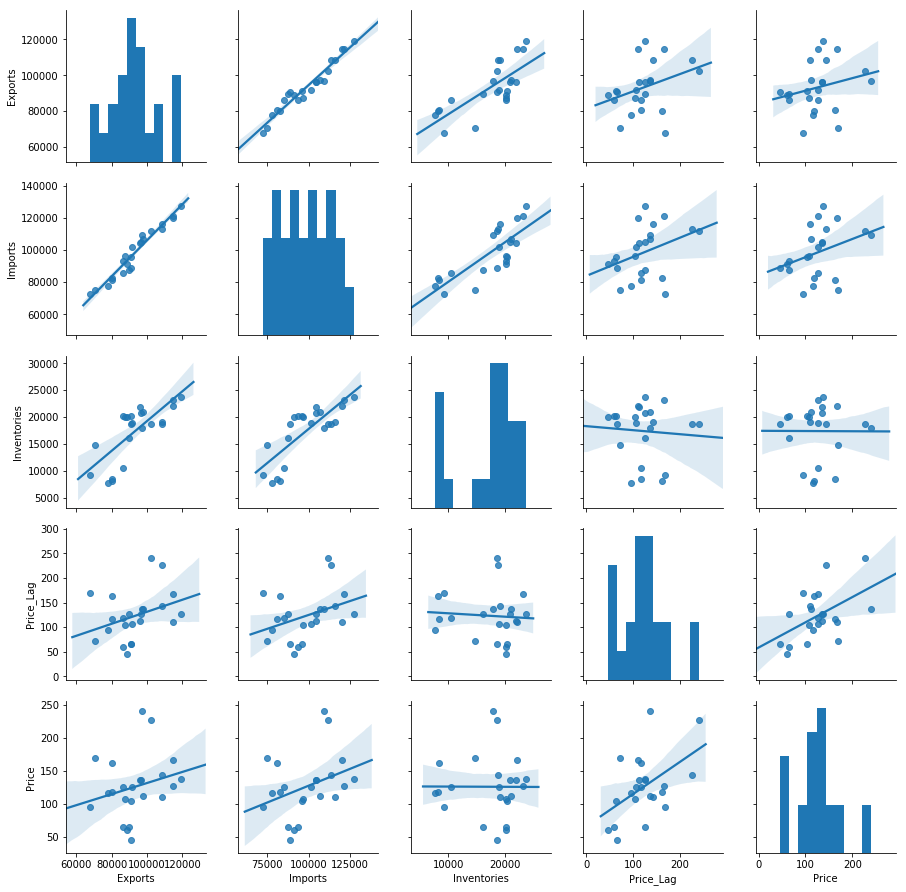

In [25]:
sns.pairplot(vars=['Exports', 'Imports', 
                   'Inventories','Price_Lag','Price'], 
             data=df,
             kind='reg');

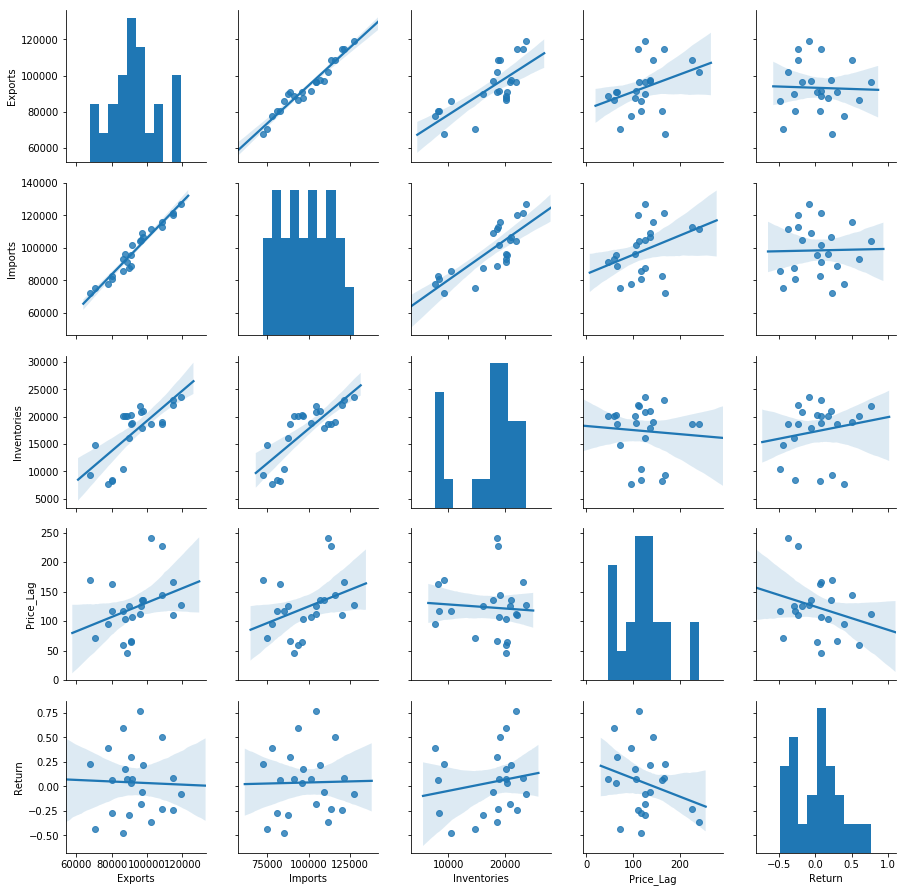

In [26]:
sns.pairplot(vars=['Exports', 'Imports', 
                   'Inventories','Price_Lag','Return'], 
             data=df,
             kind='reg');

In [27]:
X = df[['Exports', 'Imports', 'Inventories','Price_Lag']]
y = df['Price']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     79.76
Date:                Tue, 26 Feb 2019   Prob (F-statistic):           1.32e-11
Time:                        11:54:00   Log-Likelihood:                -112.21
No. Observations:                  23   AIC:                             232.4
Df Residuals:                      19   BIC:                             237.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Exports        -0.0064      0.002     -2.761      0.012      -0.011      -0.002
Imports         0.0088      0.003      3.357      0.003       0.003       0.014
Inventories    -0.0083      0.003     -2.629      0.017      -0.015      -0.002
Price_Lag       0.0335      0.219      0.153      0.880      -0.425       0.492
==============================================================================
Omnibus:                        3.497   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.088
Skew:                           0.721   Prob(JB):                        0.352
Kurtosis:                       3.319   Cond. No.                     4.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression 2: Using Levels to Predict Returns

In [28]:
X = df[['Exports', 'Imports', 'Inventories','Price_Lag']]
y = df['Return']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.8347
Date:                Tue, 26 Feb 2019   Prob (F-statistic):              0.520
Time:                        11:54:17   Log-Likelihood:                -5.1270
No. Observations:                  23   AIC:                             18.25
Df Residuals:                      19   BIC:                             22.80
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Exports     -2.113e-05   2.21e-05     -0.955      0.351   -6.74e-05    2.52e-05
Imports      2.375e-05   2.49e-05      0.955      0.351   -2.83e-05    7.58e-05
Inventories -2.418e-06      3e-05     -0.081      0.937   -6.52e-05    6.04e-05
Price_Lag      -0.0024      0.002     -1.143      0.267      -0.007       0.002
==============================================================================
Omnibus:                        1.472   Durbin-Watson:                   2.370
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.187
Skew:                           0.359   Prob(JB):                        0.552
Kurtosis:                       2.151   Cond. No.                     4.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression 3: Using Changes to Predict Returns

In [30]:
X = df[['Production', 'Disappearance', 'Exports', 'Imports', 
        'Inventories','Production_Chg', 'Disappearance_Chg', 
        'Exports_Chg', 'Imports_Chg', 'Inventories_Chg','Price_Lag']]
y = df['Return']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                 -0.108
Method:                 Least Squares   F-statistic:                    0.7965
Date:                Tue, 26 Feb 2019   Prob (F-statistic):              0.643
Time:                        11:56:06   Log-Likelihood:               -0.68409
No. Observations:                  23   AIC:                             23.37
Df Residuals:                      12   BIC:                             35.86
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Production          1.21e-05   2.53e-05      0.479      0.640   -4.29e-05    6.71e-05
Disappearance     -7.112e-06   1.94e-05     -0.367      0.720   -4.94e-05    3.51e-05
Exports            -8.94e-06   6.22e-05     -0.144      0.888      -0.000       0.000
Imports            1.186e-05   5.17e-05      0.229      0.823      -0.000       0.000
Inventories       -2.551e-05   5.31e-05     -0.481      0.639      -0.000    9.01e-05
Production_Chg    -5.307e-06   1.58e-05     -0.335      0.743   -3.98e-05    2.92e-05
Disappearance_Chg -7.827e-06   9.24e-05     -0.085      0.934      -0.000       0.000
Exports_Chg       -7.644e-06   3.69e-05     -0.207      0.839    -8.8e-05    7.27e-05
Imports_Chg       -5.779e-05   7.75e-05     -0.745      0.470      -0.000       0.000
Inventories_Chg   -6.458e-05   8.76e-05     -0.737      0.475      -0.000       0.000
Price_Lag            -0.0050      0.003     -1.503      0.159      -0.012       0.002
==============================================================================
Omnibus:                        0.591   Durbin-Watson:                   2.288
Prob(Omnibus):                  0.744   Jarque-Bera (JB):                0.126
Skew:                          -0.179   Prob(JB):                        0.939
Kurtosis:                       3.057   Cond. No.                     9.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
X = df[['Production_Chg', 'Disappearance_Chg', 'Exports_Chg', 
                   'Imports_Chg', 'Inventories_Chg','Price_Lag']]
y = df['Return']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.8879
Date:                Tue, 26 Feb 2019   Prob (F-statistic):              0.525
Time:                        11:56:33   Log-Likelihood:                -3.8536
No. Observations:                  23   AIC:                             19.71
Df Residuals:                      17   BIC:                             26.52
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Production_Chg    -2.869e-06   7.74e-06     -0.371      0.715   -1.92e-05    1.35e-05
Disappearance_Chg  5.303e-05   6.75e-05      0.785      0.443   -8.94e-05       0.000
Exports_Chg       -4.239e-05   2.77e-05     -1.530      0.144      -0.000    1.61e-05
Imports_Chg        2.517e-06   4.66e-05      0.054      0.958   -9.58e-05       0.000
Inventories_Chg   -8.112e-06   3.69e-05     -0.220      0.829   -8.59e-05    6.97e-05
Price_Lag             0.0005      0.001      0.647      0.526      -0.001       0.002
==============================================================================
Omnibus:                        7.125   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                4.909
Skew:                           1.034   Prob(JB):                       0.0859
Kurtosis:                       3.919   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression 4: Using Changes to Predict Price

In [38]:
X = df[['Production_Chg', 'Disappearance_Chg', 'Exports_Chg', 
                   'Imports_Chg', 'Inventories_Chg','Price_Lag']]
y = df['Price']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     30.70
Date:                Tue, 26 Feb 2019   Prob (F-statistic):           3.22e-08
Time:                        11:59:26   Log-Likelihood:                -116.90
No. Observations:                  23   AIC:                             245.8
Df Residuals:                      17   BIC:                             252.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Production_Chg    -2.608e-05      0.001     -0.025      0.981      -0.002       0.002
Disappearance_Chg    -0.0072      0.009     -0.780      0.446      -0.027       0.012
Exports_Chg          -0.0019      0.004     -0.497      0.626      -0.010       0.006
Imports_Chg           0.0148      0.006      2.321      0.033       0.001       0.028
Inventories_Chg      -0.0048      0.005     -0.956      0.353      -0.015       0.006
Price_Lag             0.8044      0.107      7.527      0.000       0.579       1.030
==============================================================================
Omnibus:                        6.049   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.272
Skew:                           1.032   Prob(JB):                        0.118
Kurtosis:                       3.447   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
X = df[['Production', 'Disappearance', 'Exports', 'Imports', 
        'Inventories','Production_Chg', 'Disappearance_Chg', 
        'Exports_Chg', 'Imports_Chg', 'Inventories_Chg','Price_Lag']]
y = df['Price']

model = OLS(y,X)

lr = model.fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     25.12
Date:                Tue, 26 Feb 2019   Prob (F-statistic):           1.40e-06
Time:                        11:59:59   Log-Likelihood:                -108.76
No. Observations:                  23   AIC:                             239.5
Df Residuals:                      12   BIC:                             252.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Production            0.0025      0.003      0.895      0.389      -0.004       0.009
Disappearance         0.0021      0.002      0.966      0.353      -0.003       0.007
Exports              -0.0137      0.007     -2.000      0.069      -0.029       0.001
Imports               0.0116      0.006      2.049      0.063      -0.001       0.024
Inventories          -0.0100      0.006     -1.721      0.111      -0.023       0.003
Production_Chg       -0.0015      0.002     -0.890      0.391      -0.005       0.002
Disappearance_Chg    -0.0106      0.010     -1.048      0.315      -0.033       0.011
Exports_Chg           0.0060      0.004      1.475      0.166      -0.003       0.015
Imports_Chg          -0.0011      0.009     -0.126      0.902      -0.020       0.017
Inventories_Chg       0.0022      0.010      0.234      0.819      -0.019       0.023
Price_Lag            -0.1809      0.363     -0.499      0.627      -0.971       0.609
==============================================================================
Omnibus:                        2.046   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.360   Jarque-Bera (JB):                1.365
Skew:                           0.595   Prob(JB):                        0.505
Kurtosis:                       2.907   Cond. No.                     9.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2) Time Series Analysis

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA

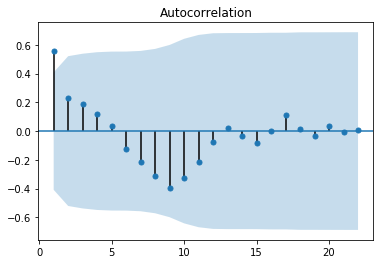

In [33]:
plot_acf(x=df['Price'], zero=False);

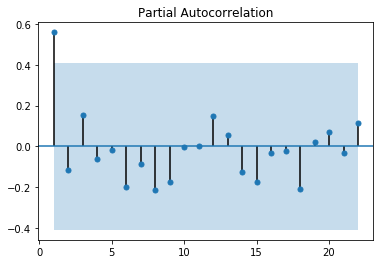

In [34]:
plot_pacf(x=df['Price'], zero=False);

In [35]:
endog=df['Price']

# Fit an AR(1) model
ar1 = ARMA(endog=endog, order=(1,0)) 

model = ar1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                   23
Model:                     ARMA(1, 0)   Log Likelihood                -116.469
Method:                       css-mle   S.D. of innovations             37.970
Date:                Tue, 26 Feb 2019   AIC                            238.939
Time:                        11:56:48   BIC                            242.345
Sample:                    12-31-1994   HQIC                           239.796
                         - 12-31-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         128.6413     17.122      7.513      0.000      95.084     162.199
ar.L1.Price     0.5591      0.168      3.330      0.003       0.230       0.888
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7886           +0.0000j            1.7886            0.0000
-----------------------------------------------------------------------------
"""

In [36]:
endog=df['Price']

# Fit an AR(1) model
ar1 = ARMA(endog=endog, order=(0,1)) 

model = ar1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                   23
Model:                     ARMA(0, 1)   Log Likelihood                -115.898
Method:                       css-mle   S.D. of innovations             36.813
Date:                Tue, 26 Feb 2019   AIC                            237.797
Time:                        11:56:50   BIC                            241.203
Sample:                    12-31-1994   HQIC                           238.654
                         - 12-31-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         128.2402     12.792     10.025      0.000     103.169     153.312
ma.L1.Price     0.6937      0.167      4.163      0.000       0.367       1.020
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4416           +0.0000j            1.4416            0.5000
-----------------------------------------------------------------------------
"""

In [37]:
endog=df['Price']

# Fit an AR(1) model
ar1 = ARMA(endog=endog, order=(1,1)) 

model = ar1.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                   23
Model:                     ARMA(1, 1)   Log Likelihood                -115.711
Method:                       css-mle   S.D. of innovations             36.533
Date:                Tue, 26 Feb 2019   AIC                            239.421
Time:                        11:56:51   BIC                            243.963
Sample:                    12-31-1994   HQIC                           240.564
                         - 12-31-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         128.9396     14.673      8.787      0.000     100.181     157.698
ar.L1.Price     0.2097      0.334      0.629      0.537      -0.444       0.864
ma.L1.Price     0.5540      0.320      1.733      0.098      -0.073       1.181
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.7681           +0.0000j            4.7681            0.0000
MA.1           -1.8049           +0.0000j            1.8049            0.5000
-----------------------------------------------------------------------------
"""